In [ ]:
import tensorflow as tf
from cv2 import (
    CLAHE,
    COLOR_BGR2GRAY,
    COLOR_GRAY2RGB,
    createCLAHE,
    cvtColor,
    resize,
)
from cv2.typing import MatLike
from divisor_de_arquivos import (
    change_dataframe_test_paths,
    change_dataframe_train_paths,
)
from keras import Model
from keras.applications import EfficientNetB3
from keras.callbacks import (
    Callback,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
    SeparableConv2D,
)
from keras.mixed_precision import Policy, set_global_policy
from keras.models import load_model, Sequential
from keras.optimizers import AdamW
from keras.regularizers import l1_l2
from matplotlib.pyplot import ioff, ion, show, subplots
from numpy import float32, ndarray, uint8, unique
from numpy.random import seed
from pandas import DataFrame, read_csv
from pandas._typing import ArrayLike
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import __version__, config, random, Tensor

# Política de precisão mista para melhorar o desempenho em GPUs compatíveis
set_global_policy(Policy("mixed_float16"))

# habilita alocamento de memória dinâmica quando necessário para GPUs
for gpu in config.list_physical_devices("GPU"):
    config.experimental.set_memory_growth(gpu, True)

# desabilita execução ansiosa para TensorFlow 1.x, (versão 2.x já tem isso desabilitado por padrão)
if int(__version__[0]) < 2:
    config.run_functions_eagerly(False)

seed(42)
random.set_seed(42)

ACTIVATION_FUNCTION: str = "relu"
BATCH_SIZE: int = 16
DROPOUT: float = 0.15
FIELD_SIZE: int = 3
FILTERS: int = 32
IMAGE_DIMENSION: int = 224
KERNEL_REGULARIZER: l1_l2 = l1_l2(l1=1e-5, l2=1e-4)
OPTIMIZER_WEIGHT_DECAY: float = 1e-4
PADDING: str = "same"
UNITS: int = 512
VERBOSE: int = 1


class GraficoAcompanhamento(Callback):
    def on_train_begin(self, logs=None):
        self.epoch: list[int] = []
        self.train_acc: list[float] = []
        self.val_acc: list[float] = []
        self.train_loss: list[float] = []
        self.val_loss: list[float] = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch + 1)
        self.train_acc.append(logs.get("accuracy"))
        self.val_acc.append(logs.get("val_accuracy"))
        self.train_loss.append(logs.get("loss"))
        self.val_loss.append(logs.get("val_loss"))

    def on_train_end(self, logs=None):
        self.fig, self.ax = subplots(ncols=2, figsize=(12, 4))
        ion()

        self.ax[0].clear()
        self.ax[1].clear()

        self.ax[0].plot(self.epoch, self.train_acc, label="Treino")
        self.ax[0].plot(self.epoch, self.val_acc, label="Validação")
        self.ax[0].set_title("Precisão")
        self.ax[0].set_xlabel("Época")
        self.ax[0].set_ylabel("Precisão")
        self.ax[0].legend()
        self.ax[0].grid(True)

        self.ax[1].plot(self.epoch, self.train_loss, label="Treino")
        self.ax[1].plot(self.epoch, self.val_loss, label="Validação")
        self.ax[1].set_title("Perda")
        self.ax[1].set_xlabel("Época")
        self.ax[1].set_ylabel("Perda")
        self.ax[1].legend()
        self.ax[1].grid(True)

        ioff()
        show()


def learning_rate_schedule(epoch: int) -> float:
    base_learning_rate: float = 0.001
    return (
        base_learning_rate
        if epoch < 10
        else (
            base_learning_rate * 0.5
            if epoch < 20
            else base_learning_rate * 0.1 if epoch < 30 else base_learning_rate * 0.01
        )
    )


def get_callbacks(model_name: str) -> list[Callback]:
    return [
        EarlyStopping(patience=15, restore_best_weights=True, verbose=VERBOSE),
        GraficoAcompanhamento(),
        ModelCheckpoint(
            f"model_fold_{model_name}.keras",
            monitor="val_accuracy",
            verbose=VERBOSE,
            save_best_only=True,
        ),
        LearningRateScheduler(learning_rate_schedule, verbose=VERBOSE),
        ReduceLROnPlateau(factor=0.3, min_lr=1e-7, patience=7, verbose=VERBOSE),
    ]


def preprocess_image(image: ndarray) -> float32:
    image: ndarray = image.astype(uint8)
    gray_scale_image: MatLike = cvtColor(image, COLOR_BGR2GRAY)
    clahe: CLAHE = createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image: MatLike = clahe.apply(gray_scale_image)
    rgb_image: MatLike = cvtColor(enhanced_image, COLOR_GRAY2RGB)
    resized_image: MatLike = resize(rgb_image, IMAGE_SIZE)
    normalized_image: float = resized_image / 255.0
    return (
        (normalized_image - normalized_image.mean()) / (normalized_image.std() + 1e-8)
    ).astype(float32)


def create_efficientnet_model(
    ACTIVATION_FUNCTION=ACTIVATION_FUNCTION,
    DRPOUT=DROPOUT,
    KERNEL_REGULARIZER=KERNEL_REGULARIZER,
    UNITS=UNITS,
) -> Model:
    base_model: Model = EfficientNetB3(
        include_top=False,
        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
        pooling="avg",
    )
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    inputs: list = base_model.input
    output: list = base_model.output

    output: Tensor = Dense(
        UNITS, activation=ACTIVATION_FUNCTION, kernel_regularizer=KERNEL_REGULARIZER
    )(output)
    output: Tensor = Dropout(DRPOUT)(output)
    output: Tensor = BatchNormalization()(output)
    output: Tensor = Dense(
        UNITS * 2, activation=ACTIVATION_FUNCTION, kernel_regularizer=KERNEL_REGULARIZER
    )(output)
    output: Tensor = Dropout(DRPOUT)(output)
    output: Tensor = BatchNormalization()(output)
    output: Tensor = Dense(
        UNITS * 2, activation=ACTIVATION_FUNCTION, kernel_regularizer=KERNEL_REGULARIZER
    )(output)
    output: Tensor = Dropout(DRPOUT)(output)
    output: Tensor = BatchNormalization()(output)
    output: Tensor = Dense(
        UNITS, activation=ACTIVATION_FUNCTION, kernel_regularizer=KERNEL_REGULARIZER
    )(output)
    output: Tensor = Dropout(0.5)(output)
    output: Tensor = BatchNormalization()(output)
    UNITS = 1
    ACTIVATION_FUNCTION = "sigmoid"
    outputs = Dense(units=UNITS, activation=ACTIVATION_FUNCTION, dtype="float32")(
        output
    )

    model: Model = Model(inputs, outputs)
    model.compile(
        optimizer=AdamW(0.005, OPTIMIZER_WEIGHT_DECAY),
        loss="binary_crossentropy",
        metrics=["accuracy", "precision", "recall", "auc"],
    )

    return model


def create_model(
    ACTIVATION_FUNCTION=ACTIVATION_FUNCTION,
    DROPOUT=DROPOUT,
    FIELD_SIZE=FIELD_SIZE,
    FILTERS=FILTERS,
    IMAGE_DIMENSION=IMAGE_DIMENSION,
    KERNEL_REGULARIZER=KERNEL_REGULARIZER,
    PADDING=PADDING,
    UNITS=UNITS,
) -> Sequential:
    inputs = Input(shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3))

    layers = Conv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(inputs)
    layers = BatchNormalization()(layers)
    layers = Conv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D()(layers)
    layers = Dropout(DROPOUT)(layers)

    FILTERS *= 2
    DROPOUT += 0.05

    layers = Conv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(inputs)
    layers = BatchNormalization()(layers)
    layers = Conv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D()(layers)
    layers = Dropout(DROPOUT)(layers)

    FILTERS *= 2
    DROPOUT += 0.05

    layers = SeparableConv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = SeparableConv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D()(layers)
    layers = Dropout(DROPOUT)(layers)

    FILTERS *= 2
    DROPOUT += 0.05

    layers = SeparableConv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = SeparableConv2D(
        FILTERS, FIELD_SIZE, activation=ACTIVATION_FUNCTION, padding=PADDING
    )(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D()(layers)
    layers = Dropout(DROPOUT)(layers)

    layers = GlobalAveragePooling2D()(layers)

    DROPOUT += 0.1

    layers = Dense(
        units=UNITS,
        activation=ACTIVATION_FUNCTION,
        kernel_regularizer=KERNEL_REGULARIZER,
    )(layers)
    layers = BatchNormalization()(layers)
    layers = Dropout(DROPOUT)(layers)

    UNITS //= 2
    DROPOUT -= 0.1

    layers = Dense(
        units=UNITS,
        activation=ACTIVATION_FUNCTION,
        kernel_regularizer=KERNEL_REGULARIZER,
    )(layers)
    layers = BatchNormalization()(layers)
    layers = Dropout(DROPOUT)(layers)

    UNITS = 1
    ACTIVATION_FUNCTION = "sigmoid"

    outputs = Dense(units=UNITS, activation=ACTIVATION_FUNCTION, dtype="float32")(
        layers
    )

    model = Model(inputs, outputs)

    model.compile(
        optimizer=AdamW(0.001, OPTIMIZER_WEIGHT_DECAY),
        loss="binary_crossentropy",
        metrics=["accuracy", "precision", "recall", "auc"],
    )
    return model


IMAGE_SIZE: tuple[int, int] = (IMAGE_DIMENSION, IMAGE_DIMENSION)

train_dataframe: DataFrame = read_csv("csv/mass_case_description_train_set.csv")
test_dataframe: DataFrame = read_csv("csv/mass_case_description_test_set.csv")

# Junta os registros de "BENIGN_WITHOUT_CALLBACK" com "BENIGN"
train_dataframe["pathology"] = train_dataframe["pathology"].replace(
    "BENIGN_WITHOUT_CALLBACK", "BENIGN"
)
train_dataframe["cropped image file path"] = train_dataframe[
    "cropped image file path"
].apply(change_dataframe_train_paths)

test_dataframe["pathology"] = test_dataframe["pathology"].replace(
    "BENIGN_WITHOUT_CALLBACK", "BENIGN"
)
test_dataframe["cropped image file path"] = test_dataframe[
    "cropped image file path"
].apply(change_dataframe_test_paths)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[0.8, 1.2],
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_image,
    rotation_range=15,
    shear_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
)

2025-11-11 18:28:12.812909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 18:28:12.823468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762896492.838190  164553 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762896492.842386  164553 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762896492.852646  164553 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


I0000 00:00:1762896592.656965  164553 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50


I0000 00:00:1762896598.175445  164711 service.cc:152] XLA service 0x72fe08020e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762896598.175479  164711 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-11-11 18:29:58.278927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762896599.100379  164711 cuda_dnn.cc:529] Loaded cuDNN version 91400
2025-11-11 18:30:50.147940: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng32{k2=2,k6=0,k13=2,k14=0,k22=2} for conv %cudnn-conv-bias-activation.19 = (f16[16,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,224,224,64]{3,2,1,0} %bitcast.26153, f16[64,3,3,64]{3,2,1,0} %bitcast.26021, f16[64]{0} %bitcast.24142), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn

 2/75 ━━━━━━━━━━━━━━━━━━━━ 59:47 49s/step - accuracy: 0.5938 - auc: 0.6705 - loss: 1.0422 - precision: 0.6360 - recall: 0.6013

2025-11-11 18:30:45.034677: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3040', 4 bytes spill stores, 4 bytes spill loads

2025-11-11 18:31:35.221647: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng10{k2=8,k13=1,k14=4,k18=0,k23=0} for conv %cudnn-conv-bias-activation.19 = (f16[2,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[2,224,224,64]{3,2,1,0} %bitcast.26150, f16[64,3,3,64]{3,2,1,0} %bitcast.26018, f16[64]{0} %bitcast.24143), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_3_1/convolution" source_file="/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend

63/75 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5501 - auc: 0.5582 - loss: 1.0927 - precision: 0.5506 - recall: 0.5669
Epoch 1: val_accuracy improved from None to 0.48485, saving model to model_fold_1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 534ms/step - accuracy: 0.5438 - auc: 0.5485 - loss: 1.0771 - precision: 0.5260 - recall: 0.5654 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8672 - val_precision: 0.4848 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
41/75 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4938 - auc: 0.5011 - loss: 1.0342 - precision: 0.5067 - recall: 0.4726   
Epoch 2: val_accuracy improved from 0.48485 to 0.51515, saving model to model_fold_1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.5329 - auc: 0.5542 - loss: 0.9840 - precision: 0.5160 - recall: 0.5340 - val_accuracy: 0.5152 - val_auc: 0.5000 - val_loss: 0.8633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

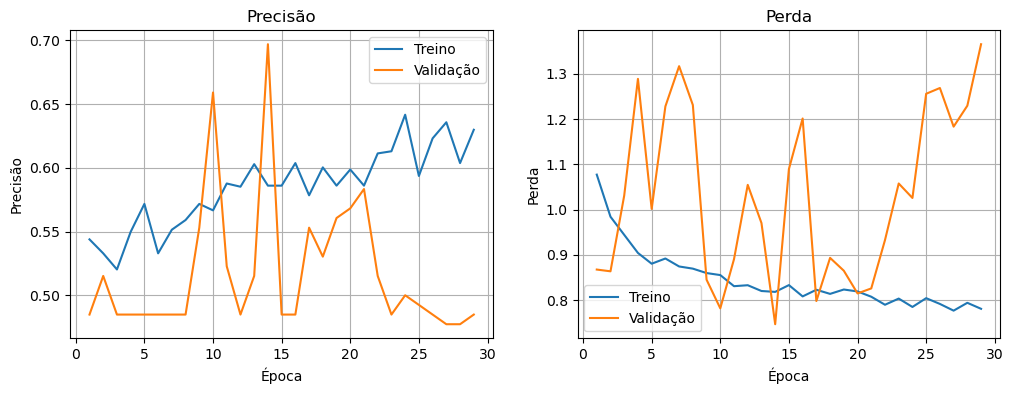

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
72/75 ━━━━━━━━━━━━━━━━━━━━ 2s 930ms/step - accuracy: 0.5126 - auc: 0.5216 - loss: 1.1102 - precision: 0.4931 - recall: 0.5501
Epoch 1: val_accuracy improved from None to 0.48485, saving model to model_fold_2.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.5371 - auc: 0.5418 - loss: 1.0667 - precision: 0.5201 - recall: 0.5428 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8902 - val_precision: 0.4848 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
47/75 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5308 - auc: 0.5558 - loss: 0.9949 - precision: 0.4865 - recall: 0.5514 
Epoch 2: val_accuracy did not improve from 0.48485
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5531 - auc: 0.5651 - loss: 0.9670 - precision: 0.5360 - recall: 0.5585 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.9284 - val_precision: 

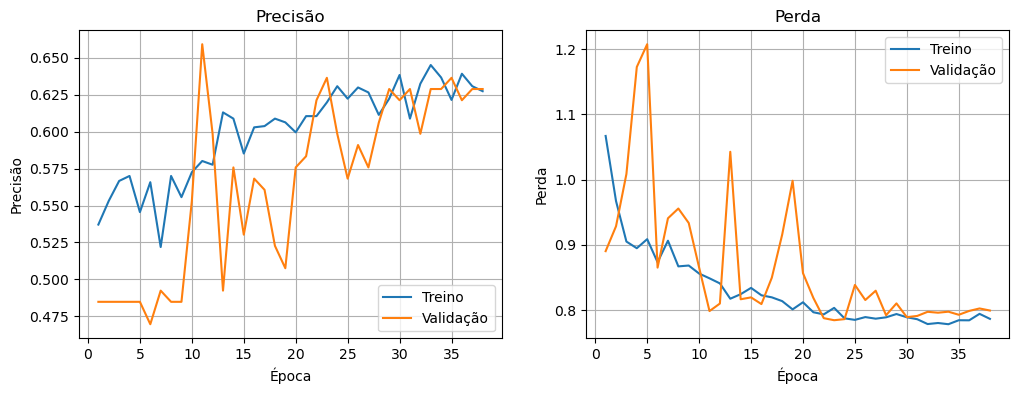

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
46/75 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5188 - auc: 0.5442 - loss: 1.1422 - precision: 0.5286 - recall: 0.5598 
Epoch 1: val_accuracy improved from None to 0.51515, saving model to model_fold_3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.5329 - auc: 0.5465 - loss: 1.0582 - precision: 0.5152 - recall: 0.5620 - val_accuracy: 0.5152 - val_auc: 0.5000 - val_loss: 0.9392 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
63/75 ━━━━━━━━━━━━━━━━━━━━ 10s 915ms/step - accuracy: 0.5475 - auc: 0.5810 - loss: 0.9174 - precision: 0.5321 - recall: 0.5779
Epoch 2: val_accuracy did not improve from 0.51515
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5329 - auc: 0.5569 - loss: 0.9431 - precision: 0.5161 - recall: 0.5323 - val_accuracy: 0.5152 - val_auc: 0.5000 - val_loss: 0.9403 - val_pr

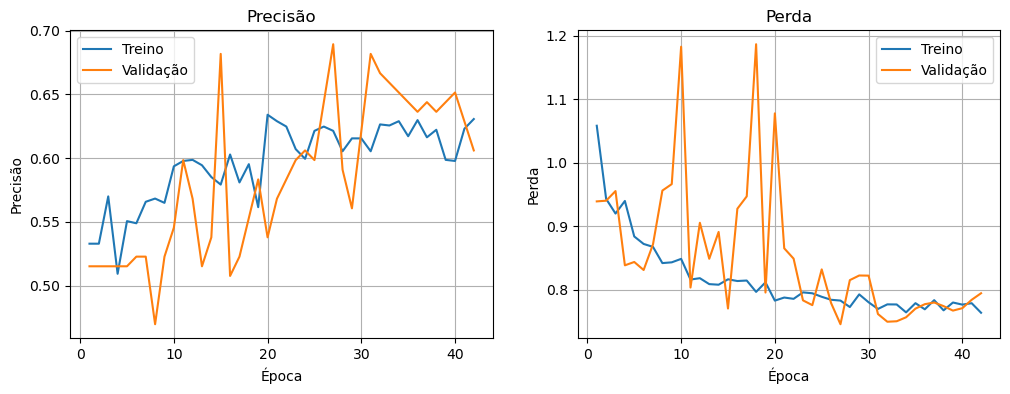

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
25/75 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.5262 - auc: 0.5121 - loss: 1.2351 - precision: 0.4828 - recall: 0.5408
Epoch 1: val_accuracy improved from None to 0.48485, saving model to model_fold_4.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 291ms/step - accuracy: 0.5261 - auc: 0.5421 - loss: 1.0694 - precision: 0.5092 - recall: 0.5323 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8610 - val_precision: 0.4848 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
52/75 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5319 - auc: 0.5321 - loss: 1.0015 - precision: 0.5374 - recall: 0.5390
Epoch 2: val_accuracy improved from 0.48485 to 0.51515, saving model to model_fold_4.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.5396 - auc: 0.5484 - loss: 1.0049 - precision: 0.5216 - recall: 0.5689 - val_accuracy: 0.5152 - val_auc: 0.485

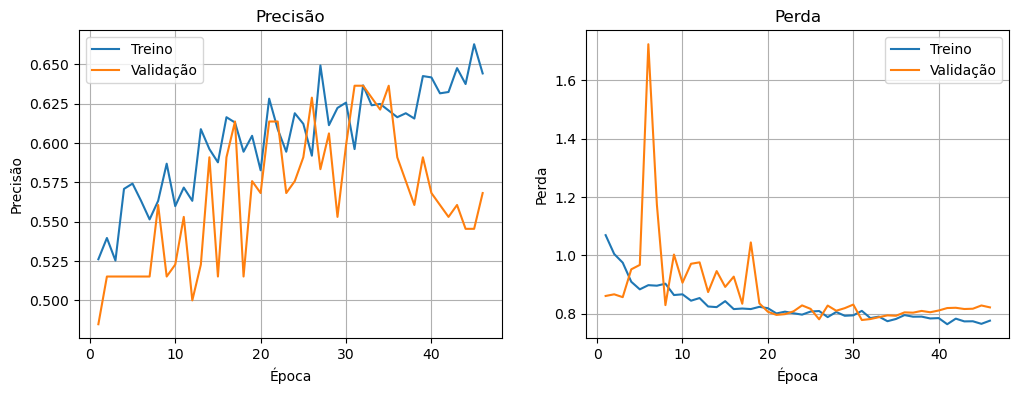

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
69/75 ━━━━━━━━━━━━━━━━━━━━ 5s 975ms/step - accuracy: 0.5182 - auc: 0.5370 - loss: 1.0820 - precision: 0.4831 - recall: 0.5280
Epoch 1: val_accuracy improved from None to 0.48485, saving model to model_fold_5.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 296ms/step - accuracy: 0.5371 - auc: 0.5593 - loss: 1.0314 - precision: 0.5195 - recall: 0.5567 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8576 - val_precision: 0.4848 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
42/75 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5782 - auc: 0.6106 - loss: 0.9802 - precision: 0.6049 - recall: 0.5952  
Epoch 2: val_accuracy did not improve from 0.48485
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5666 - auc: 0.6009 - loss: 0.9365 - precision: 0.5486 - recall: 0.5812 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.9383 - val_precision:

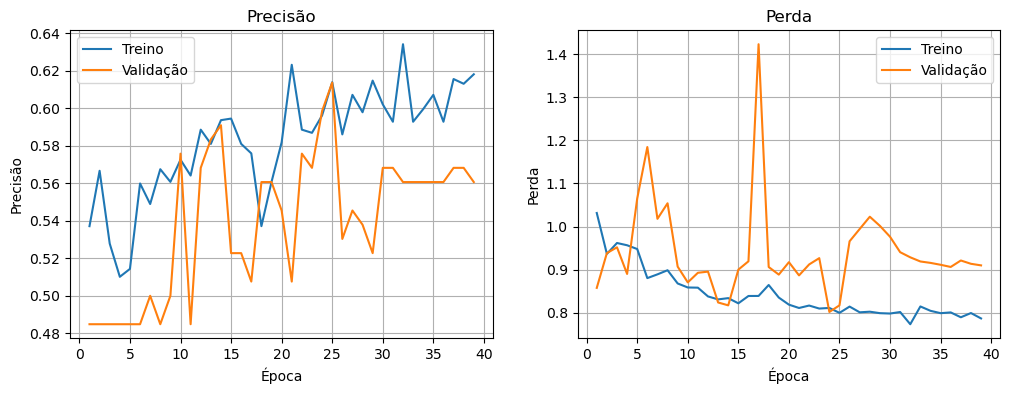

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.5354 - auc: 0.5527 - loss: 1.0639 - precision: 0.5131 - recall: 0.5504
Epoch 1: val_accuracy improved from None to 0.48485, saving model to model_fold_6.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 955ms/step - accuracy: 0.5346 - auc: 0.5552 - loss: 1.0396 - precision: 0.5171 - recall: 0.5550 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8676 - val_precision: 0.4848 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5783 - auc: 0.6168 - loss: 0.9193 - precision: 0.5601 - recall: 0.6124
Epoch 2: val_accuracy did not improve from 0.48485
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5540 - auc: 0.5893 - loss: 0.9287 - precision: 0.5368 - recall: 0.5602 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.9439 - val_precision:

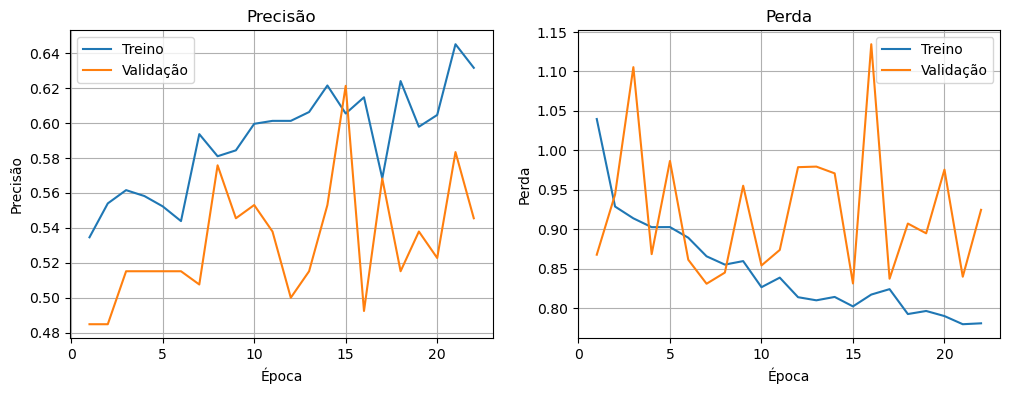

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
45/75 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4724 - auc: 0.4340 - loss: 1.2289 - precision: 0.4777 - recall: 0.5410   
Epoch 1: val_accuracy improved from None to 0.51515, saving model to model_fold_7.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.5169 - auc: 0.5199 - loss: 1.0737 - precision: 0.5000 - recall: 0.5550 - val_accuracy: 0.5152 - val_auc: 0.5000 - val_loss: 0.8508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
55/75 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5513 - auc: 0.5409 - loss: 1.0036 - precision: 0.5162 - recall: 0.5490 
Epoch 2: val_accuracy did not improve from 0.51515
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5430 - auc: 0.5638 - loss: 0.9600 - precision: 0.5268 - recall: 0.5323 - val_accuracy: 0.4848 - val_auc: 0.5000 - val_loss: 0.8933 - val_pr

IOStream.flush timed out


50/75 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6341 - auc: 0.6617 - loss: 0.7901 - precision: 0.5826 - recall: 0.6477
Epoch 26: val_accuracy did not improve from 0.56061
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6214 - auc: 0.6556 - loss: 0.7949 - precision: 0.6051 - recall: 0.6230 - val_accuracy: 0.5076 - val_auc: 0.6506 - val_loss: 1.0007 - val_precision: 0.4961 - val_recall: 0.9844 - learning_rate: 1.0000e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0001.
Epoch 27/50
50/75 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6501 - auc: 0.6968 - loss: 0.7631 - precision: 0.6372 - recall: 0.6478 
Epoch 27: val_accuracy did not improve from 0.56061
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6298 - auc: 0.6713 - loss: 0.7818 - precision: 0.6167 - recall: 0.6178 - val_accuracy: 0.4848 - val_auc: 0.6569 - val_loss: 1.3750 - val_precision: 0.4846 - val_recall: 0.9844 - learning_rate: 1.0000e-04

Epoch 28: LearningRateScheduler setting learning

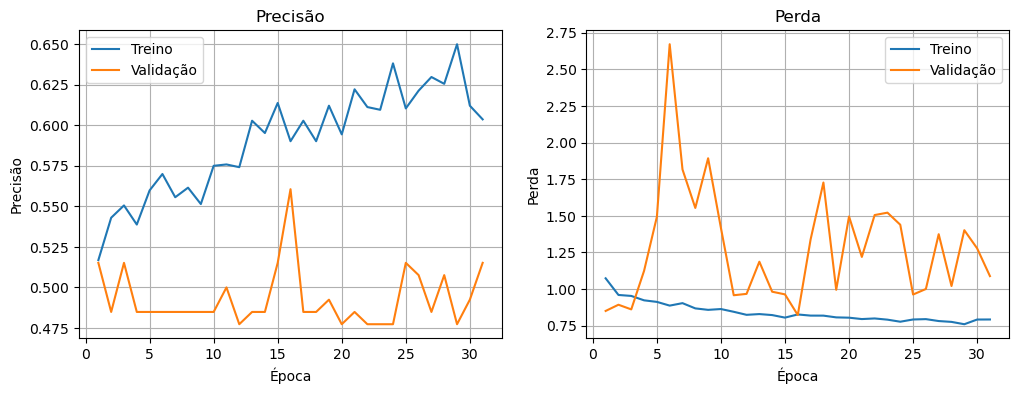

Found 1186 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
60/75 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.5243 - auc: 0.5537 - loss: 1.1041 - precision: 0.5374 - recall: 0.5831
Epoch 1: val_accuracy improved from None to 0.47727, saving model to model_fold_8.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s -370479us/step - accuracy: 0.5143 - auc: 0.5400 - loss: 1.0686 - precision: 0.4984 - recall: 0.5436 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.8650 - val_precision: 0.4773 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
72/75 ━━━━━━━━━━━━━━━━━━━━ 2s 819ms/step - accuracy: 0.5465 - auc: 0.5822 - loss: 0.9768 - precision: 0.5310 - recall: 0.5562
Epoch 2: val_accuracy did not improve from 0.47727
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5422 - auc: 0.5718 - loss: 0.9802 - precision: 0.5255 - recall: 0.5575 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.8774 - val_precis

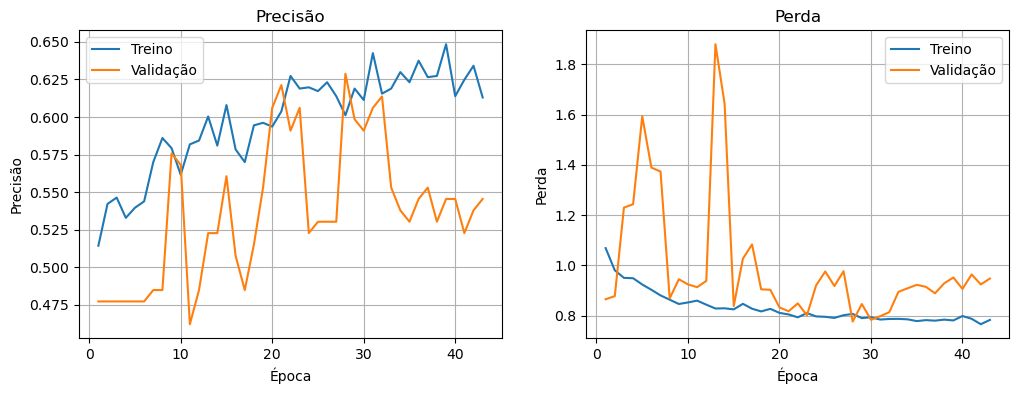

Found 1187 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
17/75 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.4377 - auc: 0.4823 - loss: 1.2224 - precision: 0.4130 - recall: 0.5188

2025-11-11 19:30:31.456653: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=0} for conv %cudnn-conv-bw-filter.11 = (f16[64,3,3,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[3,224,224,4]{3,2,1,0} %bitcast.25151, f16[3,224,224,64]{3,2,1,0} %bitcast.26146), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_8_1/conv2d_34_1/convolution/Conv2DBackpropFilter" source_file="/home/lipe/miniconda3/envs/breast_cancer/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-11-11 19:30:31.462489: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The oper

53/75 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4823 - auc: 0.5071 - loss: 1.1795 - precision: 0.4583 - recall: 0.5239 
Epoch 1: val_accuracy improved from None to 0.51908, saving model to model_fold_9.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 516ms/step - accuracy: 0.5198 - auc: 0.5434 - loss: 1.0693 - precision: 0.5033 - recall: 0.5279 - val_accuracy: 0.5191 - val_auc: 0.5000 - val_loss: 0.8545 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
71/75 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 0.5314 - auc: 0.5456 - loss: 0.9986 - precision: 0.5228 - recall: 0.5622
Epoch 2: val_accuracy did not improve from 0.51908
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5274 - auc: 0.5358 - loss: 1.0096 - precision: 0.5107 - recall: 0.5383 - val_accuracy: 0.4809 - val_auc: 0.5000 - val_loss: 0.8757 - val_precision: 0.4809 - val_recall: 1.0000 - learning_rate: 0.0010

Epoch 3: Learn

In [ ]:
models_accuracies: list[tuple[float, float]] = []
sk_fold: StratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold: int = 1
for train, val in sk_fold.split(
    train_dataframe["cropped image file path"], train_dataframe["pathology"]
):
    train_fold = train_dataframe.iloc[train].reset_index(drop=True)
    val_fold = train_dataframe.iloc[val].reset_index(drop=True)

    train_dataset = train_datagen.flow_from_dataframe(
        train_fold,
        batch_size=BATCH_SIZE,
        x_col="cropped image file path",
        y_col="pathology",
        target_size=IMAGE_SIZE,
        class_mode="binary",
        seed=42,
    )

    val_dataset = val_datagen.flow_from_dataframe(
        val_fold,
        batch_size=BATCH_SIZE,
        x_col="cropped image file path",
        y_col="pathology",
        target_size=IMAGE_SIZE,
        class_mode="binary",
        shuffle=False,
        seed=42,
    )

    pathology_encoded: ArrayLike = LabelEncoder().fit_transform(
        train_dataframe["pathology"]
    )
    class_weights: ndarray = compute_class_weight(
        "balanced", classes=unique(pathology_encoded), y=pathology_encoded
    )
    class_weights: dict = dict(enumerate(class_weights))

    model: Sequential = create_model()

    trained_model = model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        callbacks=get_callbacks(str(fold)),
        class_weight=class_weights,
        epochs=50,
        validation_data=val_dataset,
        verbose=VERBOSE,
    )
    val_accuracies: tuple[float] = trained_model.history["val_accuracy"]
    max_val_accuracy: float = max(val_accuracies)
    max_val_index: int = val_accuracies.index(max_val_accuracy)
    accuracy: tuple[float, float] = (
        max_val_accuracy,
        trained_model.history["accuracy"][max_val_index],
    )
    models_accuracies.append(accuracy)
    fold += 1

best_accuracy: float = max(models_accuracies)
best_model: int = models_accuracies.index(best_accuracy) + 1
breast_cancer_classifier = load_model(f"model_fold_{best_model}.keras")

In [ ]:
import os
import numpy as np
from keras.utils import load_img, img_to_array
from IPython.display import Image

%store breast_cancer_classifier
%store best_accuracy


diretorio_path = 'imagensCancerMama/teste_dataset'
imagens = os.listdir(diretorio_path)
index = np.random.randint(0, len(imagens))
imagem = imagens[index]
imagem_path = os.path.join(diretorio_path, imagem)

print(best_accuracy)

test_image = load_img(imagem_path, target_size=IMAGE_SIZE)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
resultado = breast_cancer_classifier.predict(test_image)
print(f"Resultado da predição: {resultado[0][0]}")
print(imagem)
print("É um câncer maligno" if resultado[0][0] >= 0.5 else "É um câncer benigno")
Image(filename=imagem_path)
